9-1 As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the efffect is real. conversely, as sample size decreases, the test is less likely to be positive even if the effect is real. To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data. You can use thinkstats2.SampleRows to select a random subset of the rows in a DataFrame. What happens to the p-values of these tests as the sample size decreases? what is the smallest sample size that yields a positive test? 

In [55]:
import pandas as pd
import thinkstats2
import thinkplot
import sys
import math
import numpy as np
import nsfg
import random
import hypothesis

In [56]:
preg = nsfg.ReadFemPreg()
live = preg[preg.outcome == 1]


In [57]:
example = thinkstats2.SampleRows(preg,2)
example
ht = hypothesis.DiffMeansPermute(example)
pvalue = ht.PValue()

ValueError: too many values to unpack (expected 2)

In [58]:
firsts = live[live.birthord == 1]
others = live[live.birthord != 1]
babies = firsts.totalwgt_lb.dropna().values, others.totalwgt_lb.dropna().values
ht = hypothesis.DiffMeansPermute(babies)
pvalue = ht.PValue()
pvalue

0.0

In [61]:
def RunTests(preg, iters=1000):
    n = len(preg)
    firsts = live[live.birthord == 1]
    others = live[live.birthord != 1]

    babies = firsts.totalwgt_lb.values, others.totalwgt_lb.values
    ht1 = hypothesis.DiffMeansPermute(babies)
    p1 = ht1.PValue()

    data = (firsts.ageatend.values,
            others.ageatend.values)
    ht2 = hypothesis.DiffMeansPermute(data)
    p2 = ht2.PValue()


    live2 = live.dropna(subset=['ageatend', 'totalwgt_lb'])
    correlation = live2.ageatend.values, live2.totalwgt_lb.values
    ht3 = hypothesis.CorrelationPermute(correlation)
    p3 = ht3.PValue()

    preg_len = firsts.prglngth.values, others.prglngth.values
    ht4 = hypothesis.PregLengthTest(preg_len)
    p4 = ht4.PValue(iters=iters)

    print(n, p1, p2, p3, p4)
RunTests(preg)

C:\Users\brean\OneDrive\Desktop\NucampFolder\projects\ThinkStats2\code\thinkstats2.py:2478: RuntimeWarning: Mean of empty slice.
  mean = xs.mean()
C:\Users\brean\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\brean\OneDrive\Desktop\NucampFolder\projects\ThinkStats2\code\thinkstats2.py:2450: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(ds, ds) / (len(xs) - ddof)
C:\Users\brean\OneDrive\Desktop\NucampFolder\projects\ThinkStats2\code\thinkstats2.py:2568: RuntimeWarning: invalid value encountered in double_scalars
  cov = np.dot(xs-meanx, ys-meany) / len(xs)


13593 0.0 0.0 0.0 0.0


So, I think I did something wrong with my code because everytime I run it, it's all zeros except for the n value. I tried to create my own values

10-1 Useing the data fromt eh BRFSS, compute the linear least squares fit for log(weight) versus height. how would you best present the estimated parameters for a model like this where one of the variables is log_transformed? if you were trying to guess someone's weight, how much would it help to know their height? LIke the NSFG, the BRFSS samples some groups ans provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is totalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the sandard error of the mean, and a 90% confidence interval. How much does correct weighting affect the estimates? 

In [17]:
import brfss
import numpy as np

%matplotlib inline

In [18]:
df = brfss.ReadBrfss()
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
weights= np.log10(weights)

In [19]:
inter,slope = thinkstats2.LeastSquares(heights, weights)
inter,slope

(0.9930804163932968, 0.005281454169417723)

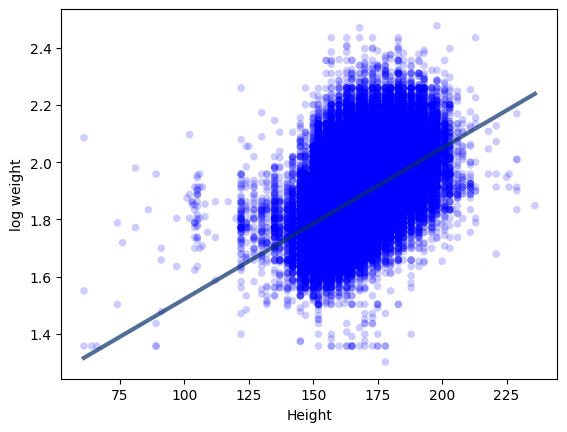

In [20]:
#logged weight
thinkplot.Scatter(heights, weights)
fit_xs, fit_ys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(fit_xs, fit_ys)
thinkplot.Config(xlabel='Height', ylabel='log weight')

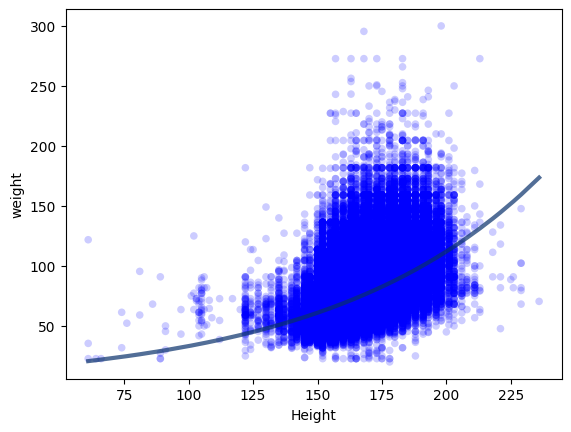

In [21]:
#weight
thinkplot.Scatter(heights, 10**weights)
fit_xs, fit_xy = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(fit_xs, 10**fit_ys)
thinkplot.Config(xlabel='Height', ylabel='weight')

C:\Users\brean\OneDrive\Desktop\NucampFolder\projects\ThinkStats2\code\thinkstats2.py:161: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self.d.update(obj.value_counts().iteritems())
C:\Users\brean\OneDrive\Desktop\NucampFolder\projects\ThinkStats2\code\thinkstats2.py:161: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self.d.update(obj.value_counts().iteritems())
C:\Users\brean\OneDrive\Desktop\NucampFolder\projects\ThinkStats2\code\thinkstats2.py:161: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self.d.update(obj.value_counts().iteritems())
C:\Users\brean\OneDrive\Desktop\NucampFolder\projects\ThinkStats2\code\thinkstats2.py:161: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self.d.update(obj.value_counts().iteritems())
C:\Users\brean\OneDrive\Desktop\NucampFolder

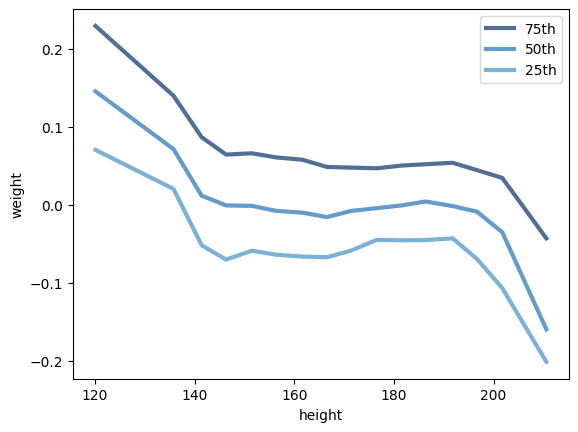

In [22]:
#percentiles mapped out
res = thinkstats2.Residuals(heights, weights, inter, slope)
df['residual'] = res

bins = np.arange(135, 210, 5)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

heights_m = [group.htm3.mean() for i, group in groups]
cdfs = [thinkstats2.Cdf(group.residual) for i, group in groups]

#thinkplot.PrePlot(3)
for percent in [75, 50, 25]:
    weights_p = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(heights_m, weights_p, label=label)
    
thinkplot.Config(xlabel='height', ylabel='weight')

In [23]:
rho = thinkstats2.Corr(heights, weights)
rho**2
#rho**2 = r2

0.28273494311893593

In [24]:
r2 = thinkstats2.CoefDetermination(weights, res)
r2

0.28273494311894043

In [25]:
std_ys = thinkstats2.Std(weights)
std_ys

0.10320725030004892

In [26]:
std_res = thinkstats2.Std(res)
std_res

0.08740777080416084

In [27]:
1 - std_res / std_ys

0.1530849765879344

In [35]:
#ht = hypothesis.SlopeTest(heights, weights)
#pvalue = ht.PValue()
#this code was in the book but not in the hypothesis py file???

In [42]:
def SampleDistribution(df,iters = 101):
    t = []
    for _ in range(100):
        sample = thinkstats2.ResampleRows(df)
        heights = sample.htm3
        weights = np.log10(sample.wtkg2)
        estimates = thinkstats2.LeastSquares(heights, weights)
        t.append(estimates)
    inters, slopes = zip(*t)
    return inters, slopes
SampleDistribution(df)

((0.9927157788412948,
  0.9920291707465496,
  0.9927076797856826,
  0.9936069876409651,
  0.9918716448237211,
  0.992068987178598,
  0.9926623345996954,
  0.9913400097026484,
  0.9934200184454398,
  0.9900936779679079,
  0.995761008917862,
  0.9921402042274013,
  0.9941422936152703,
  0.9921419296317775,
  0.9929210540479227,
  0.9883601302737018,
  0.9967646386649719,
  0.9924380718635859,
  0.9926429021193093,
  0.9926160310002937,
  0.9919291526065493,
  0.995517437101629,
  0.9925656984750685,
  0.9985124121402001,
  0.9882362220338138,
  0.9928443816386964,
  0.9949700316414185,
  0.9965707832362544,
  0.9929984727872502,
  0.9934729487218092,
  0.9928396496305733,
  0.9968615228639217,
  0.9915607490468543,
  0.9950808731735065,
  0.9951550425212808,
  0.9900002692461531,
  0.9933840251561042,
  0.9892229438318897,
  0.994561291331053,
  0.9914778911761257,
  0.9932690904756456,
  0.9935340062946407,
  0.9960160514765013,
  0.9957765565225157,
  0.9955918784375983,
  0.9971220769

In [46]:
#sample distribution 
t = []
for _ in range(100):
    sample = thinkstats2.ResampleRows(df)
    estimates = thinkstats2.LeastSquares(sample.htm3, np.log10(sample.wtkg2))
    t.append(estimates)

inters, slopes = zip(*t)

{'xscale': 'linear', 'yscale': 'linear'}

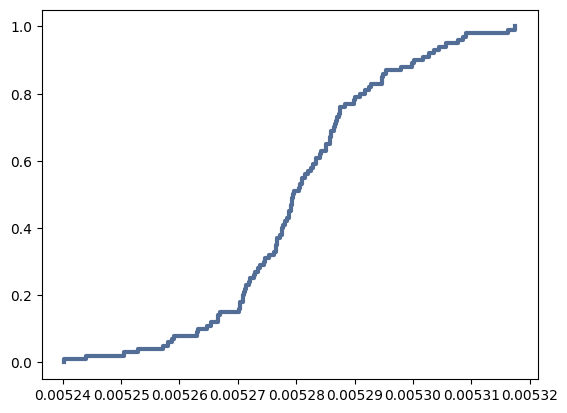

In [47]:
cdf = thinkstats2.Cdf(slopes)
thinkplot.Cdf(cdf)

In [48]:
pvalue = cdf[0]
pvalue

0

In [49]:
ci = cdf.Percentile(5), cdf.Percentile(95)
ci

(0.005257187098125266, 0.005305741584837142)

In [50]:
mean = thinkstats2.Mean(slopes)
mean

0.005280889554660215

In [51]:
stderr = thinkstats2.Std(slopes)
stderr

1.4311316019080654e-05

In [52]:
def Summarize(estimates, actual=None):
    mean = thinkstats2.Mean(estimates)
    stderr = thinkstats2.Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)
    
def ResampleRowsWeighted(df, column='finalwt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

In [53]:
estimates_unweighted = [thinkstats2.ResampleRows(df).htm3.mean() for _ in range(100)]
Summarize(estimates_unweighted)


mean, SE, CI 168.95530565997694 0.019271968870081983 (168.9191222538855, 168.9883485923321)


In [54]:
estimates_weighted = [ResampleRowsWeighted(df).htm3.mean() for _ in range(100)]
Summarize(estimates_weighted)

mean, SE, CI 170.4974604124982 0.018505130997687438 (170.46638978152347, 170.52598829806584)


looks like there is a 2cm difference between the estimated mean heights. overall this is a little over 1% difference so it doesn't seem too significant. 
